In [8]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.datasets as datasets

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
# let’s initialize the CIFAR train and test set.
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_batch_size = 4
test_batch_size = 4

In [12]:
train_loader = torch.utils.data.DataLoader(
                 dataset=cifar_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=cifar_testset,
                batch_size=test_batch_size, shuffle=False)

In [13]:
dataiter = iter(train_loader)
X_batch, y_batch = dataiter.next()

print(X_batch.shape)
print(y_batch.shape)
len(train_loader.dataset), len(test_loader.dataset)

torch.Size([4, 3, 32, 32])
torch.Size([4])


(50000, 10000)

  f r o g


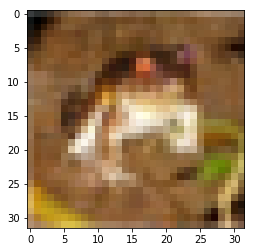

t r u c k


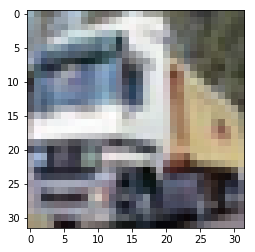

t r u c k


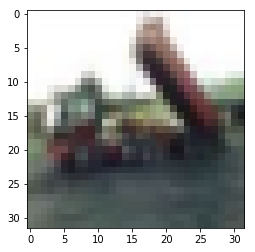

  d e e r


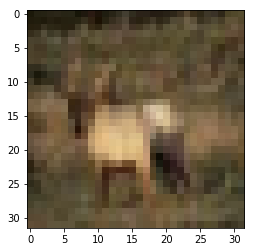

In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Showing random images from the batch
def imshow(img):
    for i in range(train_batch_size):
        img[i] = img[i] / 2 + 0.5     # unnormalize
        plt.imshow(img[i].numpy().transpose(1, 2, 0))
        print(' '.join('%5s' % classes[y_batch[i]]))
        plt.show()
          
imshow(X_batch)

In [15]:
train_batch_size = 5000
test_batch_size = 1000

In [16]:
train_loader = torch.utils.data.DataLoader(
                 dataset=cifar_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=cifar_testset,
                batch_size=test_batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [17]:
def evaluate(model):
#model = cnn
    correct = 0 
    for test_imgs, test_labels in test_loader:
        
        test_imgs = Variable(test_imgs).float()
                
        output = model.forward(test_imgs)
        
        predicted = torch.max(output,1)[1]
        
        correct += (predicted == test_labels).sum()
        accuracy = float(correct*100) / (len(test_loader)*test_batch_size)
    
    #print("Test accuracy:{:.3f} % ".format(accuracy))
    
    return accuracy

In [18]:
def fit(model, train_loader, epochs, optimizer, loss):
    
    epochs_list = []
    loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    if optimizer == 'Adam': 
        # Adam optimizer
        optimizer = torch.optim.Adam(model.parameters()) # lr=0.001, betas=(0.9,0.999))
    
    if loss == 'CrossEntropy':
        # cross entropy function
        error = nn.CrossEntropyLoss()
        
    for epoch in range(epochs):
                
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
            # and x.grad is another Variable holding the gradient of x with respect to some scalar value
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
                                    
            # we need to set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # output of the model
            output = model.forward(var_X_batch)
                        
            # Calculating the loss 
            loss = error(output, var_y_batch)
            
            # Let's do backpropogation, it will calculate all the gradients and save to x.grad
            loss.backward()
            
            # Performs a single optimization step,  
            #parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
            optimizer.step()
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            accuracy = float(correct*100) / float(train_batch_size*(batch_idx+1))
        
        # Training accuracy
        epochs_list.append(epoch)
        loss_list.append(loss.data)
        train_accuracy_list.append(accuracy)
        
        # Testing accuracy
        test_accuracy = evaluate(model)
        test_accuracy_list.append(test_accuracy)
        
        print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
            epoch+1, 
            (batch_idx+1)*(len(X_batch)), 
            len(train_loader.dataset), 
            100.*(batch_idx+1) / len(train_loader), 
            loss.data, 
            accuracy))
                                                  
    # accuracy Plot
    train_accuracy_array = np.array(train_accuracy_list)
    y_train_accuracy = train_accuracy_array.reshape(-1, 1)
    
    test_accuracy_array = np.array(test_accuracy_list)
    y_test_accuracy = test_accuracy_array.reshape(-1, 1)

    # Loss Plot
    loss_array_array = np.array(loss_list)
    y_loss = loss_array_array.reshape(-1, 1)
    
    x_epochs = np.array(epochs_list).reshape(-1, 1)
                                                  
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_epochs, y_loss)
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('epochs_vs_loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(x_epochs, y_train_accuracy, label='Training accuracy')
    plt.plot(x_epochs, y_test_accuracy, label='Testing accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('epochs_vs_accuracy')
    plt.legend()
    
    fig1 = plt.gcf()
    plt.show()
    
    # Printing Testing accuracy
    test_accuracy = evaluate(model)
    print("Test accuracy:{:.3f} % ".format(test_accuracy))

In [41]:
#VGG-8
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=(1, 1))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=(1, 1))
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1) 
        return x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Epoch : 1 [50000/50000 (100%)]	Loss: 2.166628	 Accuracy:13.030%
Epoch : 2 [50000/50000 (100%)]	Loss: 2.021989	 Accuracy:23.442%
Epoch : 3 [50000/50000 (100%)]	Loss: 1.954738	 Accuracy:27.156%
Epoch : 4 [50000/50000 (100%)]	Loss: 1.830701	 Accuracy:30.726%
Epoch : 5 [50000/50000 (100%)]	Loss: 1.808102	 Accuracy:33.654%
Epoch : 6 [50000/50000 (100%)]	Loss: 1.667354	 Accuracy:37.076%
Epoch : 7 [50000/50000 (100%)]	Loss: 1.614990	 Accuracy:39.054%
Epoch : 8 [50000/50000 (100%)]	Loss: 1.560061	 Accuracy:40.910%
Epoch : 9 [50000/50000 (100%)]	Loss: 1.508338	 Accuracy:43.128%
Epoch : 10 [50000/50000 (100%)]	Loss: 1.549502	 Accuracy:43.416%
Epoch : 11 [50000/50000 (100%)]	Loss: 1.472007	 Accuracy:44.812%
Epoch : 12 [50000/50000 (100%)]	Loss: 1.410583	 Accuracy:46.728%
Epoch : 13 [50000/50000 (100%)]	Loss: 1.397999	 Accuracy:47.158%
Epoch : 14 [50000/50000 (100%)]	Loss: 1.380605	 Accuracy:48.714%
Epoch : 15 [50000/50000 (100%)]	Loss: 1.339602	 Accuracy:50.102%
Epoch : 16 [50000/50000 (100%)]	Lo

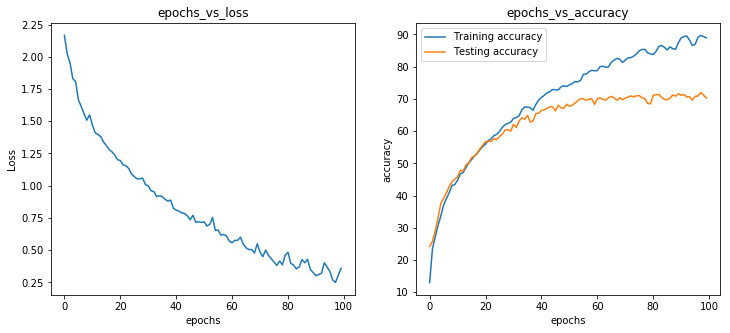

In [42]:
fit(cnn, train_loader, epochs=100, optimizer='Adam', loss='CrossEntropy')

In [43]:
#VGG-8
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=(1, 1))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=(1, 1))
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = F.relu(self.conv5(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1) 
        return x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Epoch : 1 [50000/50000 (100%)]	Loss: 2.207649	 Accuracy:13.246%
Epoch : 2 [50000/50000 (100%)]	Loss: 2.063869	 Accuracy:22.128%
Epoch : 3 [50000/50000 (100%)]	Loss: 1.989269	 Accuracy:24.990%
Epoch : 4 [50000/50000 (100%)]	Loss: 1.923231	 Accuracy:27.862%
Epoch : 5 [50000/50000 (100%)]	Loss: 1.857277	 Accuracy:30.152%
Epoch : 6 [50000/50000 (100%)]	Loss: 1.774712	 Accuracy:32.752%
Epoch : 7 [50000/50000 (100%)]	Loss: 1.683889	 Accuracy:35.812%
Epoch : 8 [50000/50000 (100%)]	Loss: 1.609975	 Accuracy:39.188%
Epoch : 9 [50000/50000 (100%)]	Loss: 1.566418	 Accuracy:41.132%
Epoch : 10 [50000/50000 (100%)]	Loss: 1.518453	 Accuracy:42.498%
Epoch : 11 [50000/50000 (100%)]	Loss: 1.470248	 Accuracy:44.230%
Epoch : 12 [50000/50000 (100%)]	Loss: 1.447844	 Accuracy:45.710%
Epoch : 13 [50000/50000 (100%)]	Loss: 1.435148	 Accuracy:46.442%
Epoch : 14 [50000/50000 (100%)]	Loss: 1.391630	 Accuracy:47.754%
Epoch : 15 [50000/50000 (100%)]	Loss: 1.344907	 Accuracy:49.106%
Epoch : 16 [50000/50000 (100%)]	Lo

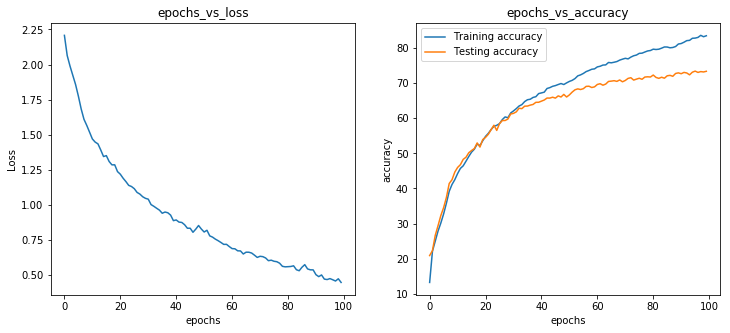

In [44]:
fit(cnn, train_loader, epochs=100, optimizer='Adam', loss='CrossEntropy')

In [47]:
#VGG-8
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=(1, 1))
        self.dropout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=(1, 1))
        self.dropout2 = nn.Dropout(0.3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))
        self.dropout3 = nn.Dropout(0.4)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 120)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = F.relu(self.conv5(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = self.dropout3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = F.log_softmax(self.fc3(x), dim=1) 
        return x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.4, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Epoch : 1 [50000/50000 (100%)]	Loss: 2.241309	 Accuracy:12.268%
Epoch : 2 [50000/50000 (100%)]	Loss: 2.092311	 Accuracy:19.756%
Epoch : 3 [50000/50000 (100%)]	Loss: 2.011049	 Accuracy:23.298%
Epoch : 4 [50000/50000 (100%)]	Loss: 1.944843	 Accuracy:25.914%
Epoch : 5 [50000/50000 (100%)]	Loss: 1.850738	 Accuracy:28.314%
Epoch : 6 [50000/50000 (100%)]	Loss: 1.813556	 Accuracy:30.840%
Epoch : 7 [50000/50000 (100%)]	Loss: 1.719326	 Accuracy:33.118%
Epoch : 8 [50000/50000 (100%)]	Loss: 1.682454	 Accuracy:35.424%
Epoch : 9 [50000/50000 (100%)]	Loss: 1.624315	 Accuracy:38.268%
Epoch : 10 [50000/50000 (100%)]	Loss: 1.642281	 Accuracy:39.842%
Epoch : 11 [50000/50000 (100%)]	Loss: 1.583829	 Accuracy:41.186%
Epoch : 12 [50000/50000 (100%)]	Loss: 1.528292	 Accuracy:42.542%
Epoch : 13 [50000/50000 (100%)]	Loss: 1.491315	 Accuracy:43.972%
Epoch : 14 [50000/50000 (100%)]	Loss: 1.454841	 Accuracy:45.462%
Epoch : 15 [50000/50000 (100%)]	Loss: 1.422828	 Accuracy:47.034%
Epoch : 16 [50000/50000 (100%)]	Lo

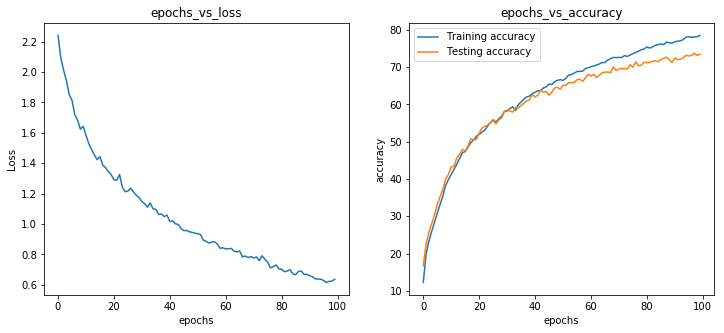

Test accuracy:78.474 % 


In [48]:
fit(cnn, train_loader, epochs=100, optimizer='Adam', loss='CrossEntropy')

In [51]:
test_accuracy = evaluate(cnn)
print("Test accuracy:{:.3f} % ".format(test_accuracy))

Test accuracy:73.610 % 


In [19]:
#VGG-8
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=(1, 1))
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=(1, 1))
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=(1, 1))
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=(1, 1))
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=(1, 1))
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.4)
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 120)
        self.dropout5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.dropout1(x)
        
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.maxpool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.dropout2(x)
        
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.maxpool(F.relu(self.batchnorm6(self.conv6(x))))
        x = self.dropout3(x)
        
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        
        x = F.log_softmax(self.fc3(x), dim=1) 
        return x

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(

Epoch : 1 [50000/50000 (100%)]	Loss: 1.974910	 Accuracy:17.450%
Epoch : 2 [50000/50000 (100%)]	Loss: 1.747108	 Accuracy:27.854%
Epoch : 3 [50000/50000 (100%)]	Loss: 1.588845	 Accuracy:34.814%
Epoch : 4 [50000/50000 (100%)]	Loss: 1.471510	 Accuracy:41.156%
Epoch : 5 [50000/50000 (100%)]	Loss: 1.386760	 Accuracy:46.606%
Epoch : 6 [50000/50000 (100%)]	Loss: 1.293222	 Accuracy:51.304%
Epoch : 7 [50000/50000 (100%)]	Loss: 1.185467	 Accuracy:55.106%
Epoch : 8 [50000/50000 (100%)]	Loss: 1.125731	 Accuracy:58.280%
Epoch : 9 [50000/50000 (100%)]	Loss: 1.102165	 Accuracy:60.236%
Epoch : 10 [50000/50000 (100%)]	Loss: 1.031793	 Accuracy:62.564%
Epoch : 11 [50000/50000 (100%)]	Loss: 0.984721	 Accuracy:64.186%
Epoch : 12 [50000/50000 (100%)]	Loss: 0.947384	 Accuracy:65.592%
Epoch : 13 [50000/50000 (100%)]	Loss: 0.906780	 Accuracy:66.946%
Epoch : 14 [50000/50000 (100%)]	Loss: 0.881497	 Accuracy:68.140%
Epoch : 15 [50000/50000 (100%)]	Loss: 0.851258	 Accuracy:69.248%
Epoch : 16 [50000/50000 (100%)]	Lo

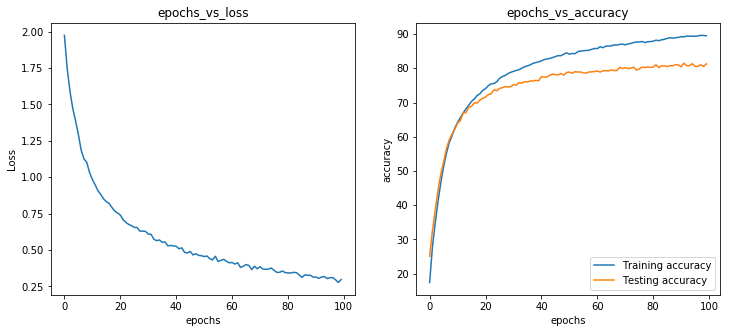

Test accuracy:81.060 % 


In [20]:
fit(cnn, train_loader, epochs=100, optimizer='Adam', loss='CrossEntropy')